## Randomized Search with Hyperopt

In this notebook, we will perform **Randomized Search** to select the best **hyperparameters** for a Gradient Boosting Classifier, using the open source Python package [Hyperopt](http://hyperopt.github.io/hyperopt/).

The randomized search is performed with the class **rand**.

I find the documentation for Hyperopt quite unintuitive, so it helps to refer to the [original article](https://iopscience.iop.org/article/10.1088/1749-4699/8/1/014008/pdf) to understand the different parameters and classes.

To step out of Scikit-learn, we will optimise the parameters of a Gradient Boosting Machine of the [xgboost package](https://xgboost.readthedocs.io/en/latest/python/python_intro.html).


### Procedure

To tune the hyper-parameters of our model we need to:

- define a model
- define the hyperparameter space
- define the objective function we want to minimize.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.datasets import load_breast_cancer
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score, train_test_split

import xgboost as xgb

from hyperopt import hp, rand, fmin, Trials

# hp: define the hyperparameter space
# rand: random search
# fmin: optimization function
# Trials: to evaluate the different searched hyperparameters

In [2]:
# load dataset

breast_cancer_X, breast_cancer_y = load_breast_cancer(return_X_y=True)
X = pd.DataFrame(breast_cancer_X)
y = pd.Series(breast_cancer_y).map({0:1, 1:0})

X.head()

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [3]:
# the target:
# percentage of benign (0) and malign tumors (1)

y.value_counts() / len(y)

0    0.627417
1    0.372583
dtype: float64

In [4]:
# split dataset into a train and test set

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=0)

X_train.shape, X_test.shape

((398, 30), (171, 30))

## Define the Hyperparameter Space

- [Hyperopt search space](http://hyperopt.github.io/hyperopt/getting-started/search_spaces/)

- [xgb.XGBClassifier hyperparameters](https://xgboost.readthedocs.io/en/latest/python/python_api.html#xgboost.XGBClassifier)

- [xgb general parameters](https://xgboost.readthedocs.io/en/latest/parameter.html)

In [5]:
# determine the hyperparameter space

param_grid = {
    'n_estimators': hp.quniform('n_estimators', 200, 2500, 100),
    'max_depth': hp.uniform('max_depth', 1, 10),
    'learning_rate': hp.uniform('learning_rate', 0.01, 0.99),
    'booster': hp.choice('booster', ['gbtree', 'dart']),
    'gamma': hp.quniform('gamma', 0.01, 10, 0.1),
    'subsample': hp.uniform('subsample', 0.50, 0.90),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.50, 0.99),
    'colsample_bylevel': hp.uniform('colsample_bylevel', 0.50, 0.99),
    'colsample_bynode': hp.uniform('colsample_bynode', 0.50, 0.99),
    'reg_lambda': hp.uniform('reg_lambda', 1, 20)
}

## Define the objective function

This is the hyperparameter response space, the function we want to minimize.

In [6]:
# the objective function takes the hyperparameter space
# as input

def objective(params):

    # we need a dictionary to indicate which value from the space
    # to attribute to each value of the hyperparameter in the xgb
    params_dict = {
        'n_estimators': int(params['n_estimators']), # important int, as it takes integers only
        'max_depth': int(params['max_depth']), # important int, as it takes integers only
        'learning_rate': params['learning_rate'],
        'booster': params['booster'],
        'gamma': params['gamma'],
        'subsample': params['subsample'],
        'colsample_bytree': params['colsample_bytree'],
        'colsample_bylevel': params['colsample_bylevel'],
        'colsample_bynode': params['colsample_bynode'],
        'random_state': 1000,
    }

    # with ** we pass the items in the dictionary as parameters
    # to the xgb
    gbm = xgb.XGBClassifier(**params_dict)

    # train with cv
    score = cross_val_score(gbm, X_train, y_train,
                            scoring='accuracy', cv=5, n_jobs=4).mean()

    # to minimize, we negate the score
    return -score

## Randomized Search

[fmin](http://hyperopt.github.io/hyperopt/getting-started/minimizing_functions/)

In [8]:
# fmin performs the minimization
# rand.suggest samples the parameters at random
# i.e., performs the random search

search = fmin(
    fn=objective,
    space=param_grid,
    max_evals=50,
    rstate=np.random.default_rng(42),
    algo=rand.suggest,  # randomized search
)

 82%|▊| 41/50 [2:49:09<5:42:59, 2286.57s/trial, best loss: -0.9674

C:\Users\Sole\Documents\Repositories\envs\homl\lib\site-packages\joblib\externals\loky\process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(



100%|█| 50/50 [3:08:02<00:00, 225.65s/trial, best loss: -0.9674050


In [9]:
# fmin returns a dictionary with the best parameters

type(search)

dict

In [10]:
search

{'booster': 0,
 'colsample_bylevel': 0.6968081788963586,
 'colsample_bynode': 0.5468589490873155,
 'colsample_bytree': 0.8873330143353462,
 'gamma': 3.1,
 'learning_rate': 0.884227960632757,
 'max_depth': 2.6776077107023877,
 'n_estimators': 900.0,
 'reg_lambda': 13.43768203715936,
 'subsample': 0.5584894776771878}

In [11]:
# create another dictionary to pass the search items as parameters
# to a new xgb

best_hp_dict = {
        'n_estimators': int(search['n_estimators']), # important int, as it takes integers only
        'max_depth': int(search['max_depth']), # important int, as it takes integers only
        'learning_rate': search['learning_rate'],
        'booster': 'gbtree',
        'gamma': search['gamma'],
        'subsample': search['subsample'],
        'colsample_bytree': search['colsample_bytree'],
        'colsample_bylevel': search['colsample_bylevel'],
        'colsample_bynode': search['colsample_bynode'],
        'random_state': 1000,
}

In [12]:
# after the search we can train the model with the
# best parameters manually

gbm_final = xgb.XGBClassifier(**best_hp_dict)

gbm_final.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=0.6968081788963586,
              colsample_bynode=0.5468589490873155,
              colsample_bytree=0.8873330143353462, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=3.1, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.884227960632757,
              max_bin=256, max_cat_to_onehot=4, max_delta_step=0, max_depth=2,
              max_leaves=0, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=900, n_jobs=0,
              num_parallel_tree=1, predictor='auto', random_state=1000,
              reg_alpha=0, reg_lambda=1, ...)

In [13]:
X_train_preds = gbm_final.predict(X_train)
X_test_preds = gbm_final.predict(X_test)

print('Train accuracy: ', accuracy_score(y_train, X_train_preds))
print('Test accuracy: ', accuracy_score(y_test, X_test_preds))

Train accuracy:  0.992462311557789
Test accuracy:  0.9590643274853801


## Evaluating the search

We can use Trials if we want to look into the search, and the performance values encountered during the process.

In [14]:
trials = Trials()

In [15]:
second_search = fmin(
    fn=objective,
    space=param_grid,
    max_evals=50,
    rstate=np.random.default_rng(42),
    algo=rand.suggest,  # randomized search
    trials = trials
)

100%|█| 50/50 [1:02:33<00:00, 75.06s/trial, best loss: -0.96740506


In [16]:
# best hyperparameters

second_search

{'booster': 0,
 'colsample_bylevel': 0.6968081788963586,
 'colsample_bynode': 0.5468589490873155,
 'colsample_bytree': 0.8873330143353462,
 'gamma': 3.1,
 'learning_rate': 0.884227960632757,
 'max_depth': 2.6776077107023877,
 'n_estimators': 900.0,
 'reg_lambda': 13.43768203715936,
 'subsample': 0.5584894776771878}

In [17]:
# the best hyperparameters can also be found in
# trials

trials.argmin

{'booster': 0,
 'colsample_bylevel': 0.6968081788963586,
 'colsample_bynode': 0.5468589490873155,
 'colsample_bytree': 0.8873330143353462,
 'gamma': 3.1,
 'learning_rate': 0.884227960632757,
 'max_depth': 2.6776077107023877,
 'n_estimators': 900.0,
 'reg_lambda': 13.43768203715936,
 'subsample': 0.5584894776771878}

In [18]:
# the search hyperparameter combinations

pd.DataFrame(trials.vals).head()

,booster,colsample_bylevel,colsample_bynode,colsample_bytree,gamma,learning_rate,max_depth,n_estimators,reg_lambda,subsample
0,0,0.737251,0.658760,0.850624,1.1,0.762499,6.865682,2200.0,12.782261,0.825462
1,0,0.667518,0.502689,0.933592,0.8,0.562807,1.539426,2200.0,12.556734,0.620169
2,1,0.826309,0.757590,0.936663,8.2,0.571274,2.414617,1600.0,2.399559,0.558785
3,0,0.623687,0.785930,0.600911,5.0,0.082438,7.340140,1600.0,5.032125,0.661511
4,0,0.832376,0.873171,0.746166,4.0,0.341402,4.115067,900.0,2.836248,0.701162


In [19]:
# the results

pd.DataFrame(trials.results).head()

,loss,status
0,-0.947247,ok
1,-0.964873,ok
2,-0.942184,ok
3,-0.939747,ok
4,-0.944747,ok


In [20]:
results = pd.concat([
    pd.DataFrame(trials.vals),
    pd.DataFrame(trials.results)],
    axis=1,
).sort_values(by='loss', ascending=False).reset_index(drop=True)

results.head()

,booster,colsample_bylevel,colsample_bynode,colsample_bytree,gamma,learning_rate,max_depth,n_estimators,reg_lambda,subsample,loss,status
0,0,0.711479,0.565276,0.576124,9.5,0.506087,8.824203,400.0,19.942757,0.779631,-0.927152,ok
1,1,0.947287,0.663653,0.856963,7.4,0.147014,4.032818,1900.0,16.771703,0.525715,-0.932215,ok
2,0,0.800030,0.596640,0.755243,6.1,0.802608,2.951827,1600.0,14.870752,0.613264,-0.934652,ok
3,0,0.707979,0.852354,0.538706,8.3,0.837293,5.307401,2200.0,12.143680,0.656224,-0.937152,ok
4,0,0.600675,0.545271,0.774166,6.8,0.077474,5.381558,700.0,6.927344,0.751204,-0.937184,ok


Text(0.5, 0, 'Hyperparam combination')

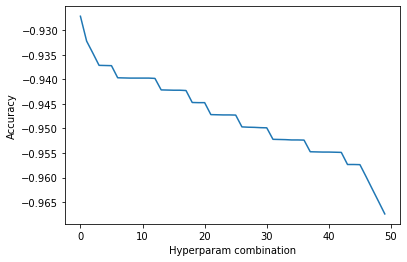

In [21]:
results['loss'].plot()
plt.ylabel('Accuracy')
plt.xlabel('Hyperparam combination')

In [22]:
pd.DataFrame(trials.results)['loss'].min()

-0.9674050632911392